In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# Should Olist remove under-performing sellers from its marketplace?

In [3]:
from olist.seller import Seller

/home/elise/code/elisearnal/04-Decision-Science/01-Project-Setup/data-context-and-setup/olist


## Data preparation : add revenues, costs_of_reviews and profits per seller

In [4]:
sellers = Seller().get_training_data()
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,review_score,share_of_five_stars,share_of_one_stars,costs_of_reviews,revenues,profits
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000,218.70,3.00,0.333333,0.333333,140,341.870,201.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,1.025,11703.07,4.55,0.725000,0.050000,240,2290.307,2050.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,1,1,1.000,158.00,5.00,1.000000,0.000000,0,15.800,15.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,1,1,1.000,79.99,5.00,1.000000,0.000000,0,7.999,7.999
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1,1,1.000,167.99,1.00,0.000000,1.000000,100,16.799,-83.201


In [17]:
print("Total cumulated profits (BRL):", sellers["profits"].sum())

Total cumulated profits (BRL): 1167608.4440000001


In [16]:
total_revenue = sellers["revenues"].sum()
print("Total cumulated revenues (BRL):", total_revenue)

Total cumulated revenues (BRL): 2785818.444


## Calculate the IT costs according to sellers

In [6]:
def IT_costs(df):
    alpha = 3157.27
    beta = 978.23
    return alpha * (df["seller_id"].count())**0.5 + beta * (df["quantity"].sum())**0.5

In [7]:
print("Current actual IT costs (BRL): ", IT_costs(sellers))

Current actual IT costs (BRL):  499999.31851932954


## Calculate the total margin according to sellers

In [8]:
def margin_olist(df, sellers_to_remove):
    my_df = df.copy()
    # on trie les sellers par profit
    my_df.sort_values(by="profits", ascending=True, inplace=True)
    my_df.reset_index(inplace=True)
    #on calcule le profit total en enlevant les sellers les moins profitables
    total_profits = my_df.loc[sellers_to_remove:,"profits"].sum()
    #on calcule les coûts IT
    total_IT_costs = IT_costs(my_df.loc[sellers_to_remove:, ])
#     print(f"Total margin with {sellers_to_remove} sellers removed : {total_profits - total_IT_costs}.")
    return total_profits - total_IT_costs

In [9]:
print("Current total margin (BRL): ", margin_olist(sellers, 0))

Current total margin (BRL):  667609.1254806706


## Plot the margin according to the number of sellers to remove

In [10]:
sellers_to_remove = np.linspace(0, sellers.shape[0], sellers.shape[0], dtype=int)
margin_per_sellers_to_remove = pd.DataFrame()
margin_per_sellers_to_remove["sellers_to_remove"] = sellers_to_remove
margin_per_sellers_to_remove["margin"] = margin_per_sellers_to_remove["sellers_to_remove"].apply(lambda x: margin_olist(sellers,x))
margin_per_sellers_to_remove.set_index("sellers_to_remove",inplace=True)

In [11]:
margin_per_sellers_to_remove.head()

,margin
sellers_to_remove,
0,667609.125481
1,692136.571883
2,712856.431848
3,733114.115269
4,750492.262699


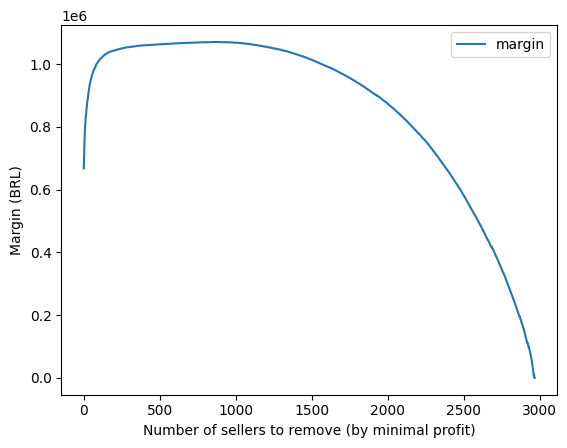

In [12]:
plt.plot(margin_per_sellers_to_remove.index, margin_per_sellers_to_remove["margin"], label="margin");
plt.legend()
plt.xlabel("Number of sellers to remove (by minimal profit)")
plt.ylabel("Margin (BRL)");

In [13]:
optimal_seller_to_remove = margin_per_sellers_to_remove["margin"].idxmax()
print("The optimal number of sellers to remove, starting by the less profitable ones, is:", optimal_seller_to_remove)

The optimal number of sellers to remove, starting by the less profitable ones, is: 855


# Should Olist remove the worst performing products / categories from its marketplace entirely?

In [76]:
from olist.product import Product

In [77]:
products = Product().get_training_data()
products.head()

,product_id,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,category,wait_time,price,share_of_one_stars,share_of_five_stars,review_score,n_orders,quantity,sales
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,3.017639,10.910000,0.0,1.0,5.0,1,1,10.91
1,6a2fb4dd53d2cdb88e0432f1284a004c,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery,10.275272,16.900000,0.0,0.5,3.5,2,2,33.80
2,0d009643171aee696f4733340bc2fdd0,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery,13.933686,325.627273,0.2,0.4,3.7,10,11,3581.90
3,b1eae565a61935e0011ee7682fef9dc9,49.0,460.0,2.0,267.0,17.0,13.0,17.0,perfumery,21.219062,399.900000,0.0,0.0,2.0,1,1,399.90
4,8da90b37f0fb171b4877c124f965b1f6,56.0,733.0,3.0,377.0,18.0,13.0,15.0,perfumery,8.965984,137.900000,0.0,1.0,5.0,1,1,137.90


## Simple correlation analysis

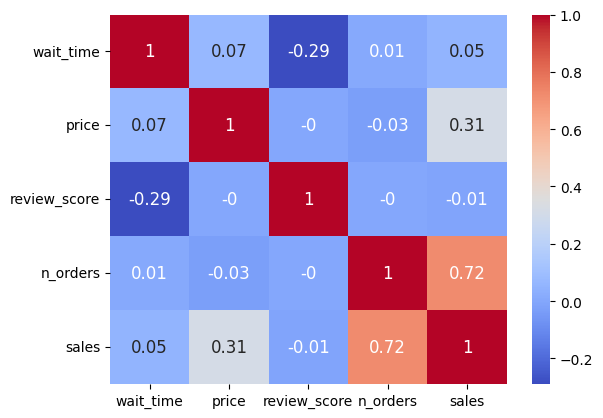

In [95]:
sns.heatmap(round(products[["category", "wait_time","price", "review_score","n_orders","sales"]].corr(),2), cmap = "coolwarm", annot = True, annot_kws = {"size":12});

## Plot the average review_score according to categories

In [133]:
worst_categories = products.copy()

In [134]:
worst_categories = worst_categories[["category", "review_score"]].groupby("category").mean().sort_values(by="review_score")
worst_categories.head()

,review_score
category,
security_and_services,2.500000
furniture_mattress_and_upholstery,3.218939
fashio_female_clothing,3.608974
fashion_male_clothing,3.739583
audio,3.755233


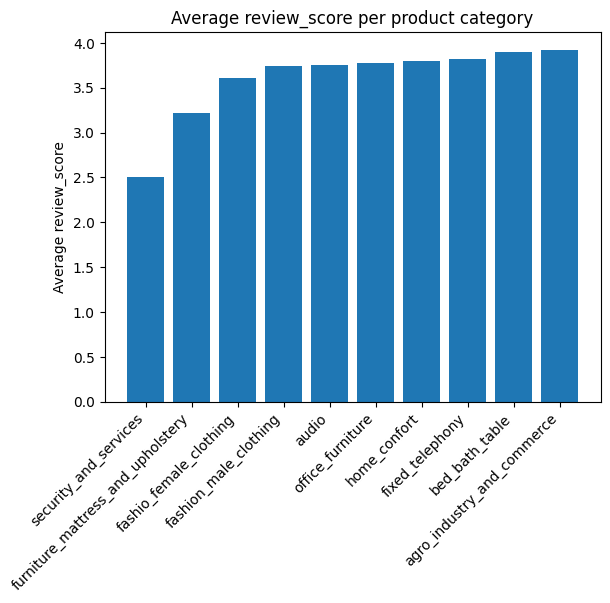

In [147]:
plt.bar(x=worst_categories.index[0:10], height=worst_categories["review_score"][0:10])
plt.xticks(rotation=45, ha='right');
plt.ylabel("Average review_score");
plt.title("Average review_score per product category");

## What if Olist remove the worst product categories from its marketplace ?

In [148]:
new_sellers = Seller()
# add product category in "order_items"
new_sellers.data["order_items"] = new_sellers.data["order_items"].merge(new_sellers.data["products"][["product_id", "product_category_name"]], on="product_id")\
.merge(new_sellers.data["product_category_name_translation"], on="product_category_name")\
.drop(['product_category_name'], axis=1)
new_sellers.data["order_items"] 
categories_to_remove = [cat for cat in worst_categories.index[0:10]]
print("Categories to remove :", categories_to_remove)
new_sellers.data["order_items"] = new_sellers.data["order_items"][~new_sellers.data["order_items"]["product_category_name_english"].isin(categories_to_remove)]
new_sellers.data["order_items"] = new_sellers.data["order_items"].drop(['product_category_name_english'], axis=1)
new_sellers.data["order_items"].head()

Categories to remove : ['security_and_services', 'furniture_mattress_and_upholstery', 'fashio_female_clothing', 'fashion_male_clothing', 'audio', 'office_furniture', 'home_confort', 'fixed_telephony', 'bed_bath_table', 'agro_industry_and_commerce']


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29


In [149]:
print("Initial total margin (BRL):", margin_olist(sellers, 0))
print("New total margin (BRL): ", margin_olist(new_sellers.get_training_data(), 0))

Initial total margin (BRL): 667609.1254806706
New total margin (BRL):  705998.6651890957


## Linear regressions

### Data preparation : sales weighting by bad reviews

We know that bad reviews have an impact on Olist profit. We can create a knew set of data which will consider 10% Olist cut on sales - an amount on products which have an average review_score less than 3.

In [86]:
my_products = products.copy()

In [87]:
my_products["weighted_revenues"] = my_products["sales"]*0.1 -\
my_products.apply(lambda row: row["sales"]*0.30 if row["review_score"] < 2\
                  else row["sales"]*0.10 if row["review_score"] < 3\
                  else 0, axis=1)
my_products.head()

,product_id,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,category,wait_time,price,share_of_one_stars,share_of_five_stars,review_score,n_orders,quantity,sales,weighted_revenues
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,3.017639,10.910000,0.0,1.0,5.0,1,1,10.91,1.091
1,6a2fb4dd53d2cdb88e0432f1284a004c,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery,10.275272,16.900000,0.0,0.5,3.5,2,2,33.80,3.380
2,0d009643171aee696f4733340bc2fdd0,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery,13.933686,325.627273,0.2,0.4,3.7,10,11,3581.90,358.190
3,b1eae565a61935e0011ee7682fef9dc9,49.0,460.0,2.0,267.0,17.0,13.0,17.0,perfumery,21.219062,399.900000,0.0,0.0,2.0,1,1,399.90,0.000
4,8da90b37f0fb171b4877c124f965b1f6,56.0,733.0,3.0,377.0,18.0,13.0,15.0,perfumery,8.965984,137.900000,0.0,1.0,5.0,1,1,137.90,13.790


### Data standardization

#### Regression of sales

In [88]:
features = ["review_score", "price", "wait_time"]

In [89]:
products_scaled = pd.DataFrame()
products_scaled[["product_id", "category", "sales", "weighted_revenues"]] = my_products[["product_id", "category", "sales", "weighted_revenues"]]
for feature in features:
    mu = my_products[feature].mean()
    sigma = my_products[feature].std()
    products_scaled[feature] = my_products[feature].apply(lambda x: (x-mu)/sigma)
products_scaled.head()

,product_id,category,sales,weighted_revenues,review_score,price,wait_time
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery,10.91,1.091,0.775088,-0.549566,-1.101806
1,6a2fb4dd53d2cdb88e0432f1284a004c,perfumery,33.80,3.380,-0.531302,-0.524959,-0.223766
2,0d009643171aee696f4733340bc2fdd0,perfumery,3581.90,358.190,-0.357116,0.743302,0.218835
3,b1eae565a61935e0011ee7682fef9dc9,perfumery,399.90,0.000,-1.837691,1.048417,1.100232
4,8da90b37f0fb171b4877c124f965b1f6,perfumery,137.90,13.790,0.775088,-0.027887,-0.382166


#### Regression of Review_score

In [99]:
features = ["sales", "weighted_revenues", "price", "wait_time"]

In [100]:
products_scaled2 = pd.DataFrame()
products_scaled2[["product_id", "category", "review_score"]] = my_products[["product_id", "category", "review_score"]]
for feature in features:
    mu = my_products[feature].mean()
    sigma = my_products[feature].std()
    products_scaled2[feature] = my_products[feature].apply(lambda x: (x-mu)/sigma)
products_scaled2.head()

,product_id,category,review_score,sales,weighted_revenues,price,wait_time
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery,5.0,-0.293878,-0.240591,-0.549566,-1.101806
1,6a2fb4dd53d2cdb88e0432f1284a004c,perfumery,3.5,-0.277420,-0.224442,-0.524959,-0.223766
2,0d009643171aee696f4733340bc2fdd0,perfumery,3.7,2.273700,2.278720,0.743302,0.218835
3,b1eae565a61935e0011ee7682fef9dc9,perfumery,2.0,-0.014191,-0.248288,1.048417,1.100232
4,8da90b37f0fb171b4877c124f965b1f6,perfumery,5.0,-0.202571,-0.151000,-0.027887,-0.382166


### Determine which categories impact the most the Olist performance with linear regressions

#### Linear regression of weighted revenues on products categories

In [90]:
model = smf.ols(formula = 'weighted_revenues ~ C(category)', data=products_scaled).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      weighted_revenues   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     17.99
Date:                Thu, 02 Nov 2023   Prob (F-statistic):          1.08e-212
Time:                        16:27:21   Log-Likelihood:            -2.0003e+05
No. Observations:               31484   AIC:                         4.002e+05
Df Residuals:                   31413   BIC:                         4.008e+05
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                 34.0820     16.513      2.064      0.039       1.716      66.448
C(category)[T.air_conditioning]                           -4.8627     20.833     -0.233      0.815     -45.696      35.971
C(category)[T.art]                                         9.3260     25.540      0.365      0.715     -40.733      59.385
C(category)[T.arts_and_craftmanship]                     -28.0654     35.939     -0.781      0.435     -98.508      42.377
C(category)[T.audio]                                      46.3934     24.627      1.884      0.060      -1.876      94.663
C(category)[T.auto]                                      -14.3488     16.828     -0.853      0.394     -47.331      18.634
C(category)[T.baby]                                       -1.8713     17.163     -0.109      0.913     -35.511      31.768
C(category)[T.bed_bath_table]                             -5.5465     16.709     -0.332      0.740     -38.297      27.204
C(category)[T.books_general_interest]                    -12.6828     19.137     -0.663      0.507     -50.191      24.826
C(category)[T.books_imported]                            -21.4855     30.299     -0.709      0.478     -80.872      37.901
C(category)[T.books_technical]                           -20.4079     20.769     -0.983      0.326     -61.117      20.301
C(category)[T.cds_dvds_musicals]                          38.9180    140.117      0.278      0.781    -235.717     313.553
C(category)[T.christmas_supplies]                        -21.0298     24.186     -0.870      0.385     -68.434      26.375
C(category)[T.cine_photo]                                -13.5058     31.895     -0.423      0.672     -76.022      49.010
C(category)[T.computers]                                 697.1736     30.664     22.736      0.000     637.071     757.276
C(category)[T.computers_accessories]                      12.5154     16.876      0.742      0.458     -20.562      45.593
C(category)[T.consoles_games]                              2.2739     18.369      0.124      0.901     -33.731      38.278
C(category)[T.construction_tools_construction]            -3.5540     17.946     -0.198      0.843     -38.729      31.621
C(category)[T.construction_tools_lights]                  15.4536     22.966      0.673      0.501     -29.560      60.467
C(category)[T.construction_tools_safety]                  -3.3284     22.196     -0.150      0.881     -46.834      40.177
C(category)[T.cool_stuff]                                 39.4600     17.264      2.286      0.022       5.622      73.299
C(category)[T.costruction_tools_garden]                   -7.5226     22.311     -0.337      0.736     -51.254      36.209
C(catego

In [91]:
pd.DataFrame(model.params.sort_values())

,0
C(category)[T.fixed_telephony],-55.939559
C(category)[T.security_and_services],-34.917514
C(category)[T.dvds_blu_ray],-29.281014
C(category)[T.fashion_male_clothing],-29.012548
C(category)[T.arts_and_craftmanship],-28.065383
...,...
C(category)[T.audio],46.393382
C(category)[T.watches_gifts],49.833353
C(category)[T.home_appliances_2],70.517850
C(category)[T.small_appliances_home_oven_and_coffee],113.509919


> It seems that some products categories have a bad impact on sales. Top 5 worst products categories are : fixed_telephony, security_and_services, dvds_blu_ray, fashion_male_clothing, arts_and_craftmanship.

> On the contrary some categories seem to have a good impact on wheighted sales : computers, small_appliances_home_oven_and_coffee, home_appliances_2, watches_gifts, audio. Olist could make a marketting effort to increase these sales.

#### Linear regression of sales on products categories, price and review_score

In [97]:
model2 = smf.ols(formula = 'sales ~ C(category) + review_score + price + wait_time', data=products_scaled).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     55.65
Date:                Thu, 02 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:39:06   Log-Likelihood:            -2.7061e+05
No. Observations:               31482   AIC:                         5.414e+05
Df Residuals:                   31408   BIC:                         5.420e+05
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                536.1785    155.801      3.441      0.001     230.802     841.555
C(category)[T.air_conditioning]                         -183.6682    196.326     -0.936      0.350    -568.474     201.138
C(category)[T.art]                                      -161.5291    240.638     -0.671      0.502    -633.189     310.131
C(category)[T.arts_and_craftmanship]                    -289.2866    338.689     -0.854      0.393    -953.131     374.558
C(category)[T.audio]                                     376.2030    232.153      1.620      0.105     -78.826     831.232
C(category)[T.auto]                                     -234.3718    158.744     -1.476      0.140    -545.517      76.773
C(category)[T.baby]                                     -113.3312    161.860     -0.700      0.484    -430.583     203.921
C(category)[T.bed_bath_table]                           -133.3540    157.716     -0.846      0.398    -442.484     175.776
C(category)[T.books_general_interest]                   -176.0210    180.669     -0.974      0.330    -530.139     178.097
C(category)[T.books_imported]                           -287.1546    285.562     -1.006      0.315    -846.866     272.557
C(category)[T.books_technical]                          -259.9907    195.970     -1.327      0.185    -644.100     124.119
C(category)[T.cds_dvds_musicals]                         347.6003   1319.559      0.263      0.792   -2238.787    2933.987
C(category)[T.christmas_supplies]                       -258.8892    228.112     -1.135      0.256    -705.999     188.220
C(category)[T.cine_photo]                               -280.2350    300.503     -0.933      0.351    -869.232     308.762
C(category)[T.computers]                                5271.3207    289.724     18.194      0.000    4703.450    5839.191
C(category)[T.computers_accessories]                       8.5949    159.198      0.054      0.957    -303.440     320.630
C(category)[T.consoles_games]                            -83.1865    173.223     -0.480      0.631    -422.711     256.338
C(category)[T.construction_tools_construction]          -217.6811    169.216     -1.286      0.198    -549.351     113.989
C(category)[T.construction_tools_lights]                   1.4968    216.483      0.007      0.994    -422.819     425.813
C(category)[T.construction_tools_safety]                -305.1135    209.089     -1.459      0.145    -714.937     104.710
C(category)[T.cool_stuff]                                170.9885    162.762      1.051      0.293    -148.032     490.009
C(category)[T.costruction_tools_garden]                 -184.6949    210.371     -0.878      0.380    -597.031     227.641
C(catego

In [93]:
pd.DataFrame(model2.params.sort_values())

,0
C(category)[T.security_and_services],-408.429361
C(category)[T.fashion_male_clothing],-334.043092
C(category)[T.la_cuisine],-328.719270
C(category)[T.fashio_female_clothing],-321.312066
C(category)[T.dvds_blu_ray],-317.131254
...,...
price,385.865657
C(category)[T.tablets_printing_image],401.786583
Intercept,536.178520
C(category)[T.small_appliances_home_oven_and_coffee],638.233301


> It seems that some products categories have a bad impact on sales. Top 5 worst products categories are : security_and_services, fashion_male_clothing, la_cuisine, fashio_female_clothing, dvds_blu_ray.

#### Linear regression of review scores on product categories, wait_time, price, sales

In [106]:
model3 = smf.ols(formula = 'review_score ~ C(category) + sales + weighted_revenues + price + wait_time', data=products_scaled2).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     68.61
Date:                Thu, 02 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:50:19   Log-Likelihood:                -46660.
No. Observations:               31482   AIC:                         9.347e+04
Df Residuals:                   31407   BIC:                         9.410e+04
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                  4.0417      0.127     31.858      0.000       3.793       4.290
C(category)[T.air_conditioning]                           -0.0568      0.160     -0.356      0.722      -0.370       0.256
C(category)[T.art]                                         0.1746      0.196      0.891      0.373      -0.209       0.559
C(category)[T.arts_and_craftmanship]                       0.0779      0.276      0.282      0.778      -0.462       0.618
C(category)[T.audio]                                      -0.2446      0.189     -1.294      0.196      -0.615       0.126
C(category)[T.auto]                                        0.0879      0.129      0.680      0.496      -0.165       0.341
C(category)[T.baby]                                        0.0349      0.132      0.265      0.791      -0.223       0.293
C(category)[T.bed_bath_table]                             -0.1182      0.128     -0.921      0.357      -0.370       0.133
C(category)[T.books_general_interest]                      0.4362      0.147      2.966      0.003       0.148       0.724
C(category)[T.books_imported]                              0.2045      0.232      0.880      0.379      -0.251       0.660
C(category)[T.books_technical]                             0.3817      0.160      2.393      0.017       0.069       0.694
C(category)[T.cds_dvds_musicals]                           0.5687      1.074      0.530      0.596      -1.536       2.674
C(category)[T.christmas_supplies]                          0.2314      0.186      1.246      0.213      -0.133       0.595
C(category)[T.cine_photo]                                 -0.0648      0.245     -0.265      0.791      -0.544       0.415
C(category)[T.computers]                                  -0.2755      0.237     -1.160      0.246      -0.741       0.190
C(category)[T.computers_accessories]                       0.0015      0.130      0.012      0.991      -0.253       0.256
C(category)[T.consoles_games]                              0.1746      0.141      1.238      0.216      -0.102       0.451
C(category)[T.construction_tools_construction]             0.0341      0.138      0.247      0.805      -0.236       0.304
C(category)[T.construction_tools_lights]                  -0.1177      0.176     -0.668      0.504      -0.463       0.228
C(category)[T.construction_tools_safety]                  -0.0920      0.170     -0.540      0.589      -0.426       0.242
C(category)[T.cool_stuff]                                  0.1482      0.133      1.118      0.263      -0.112       0.408
C(category)[T.costruction_tools_garden]                    0.0377      0.171      0.220      0.826      -0.298       0.373
C(catego

In [107]:
pd.DataFrame(model3.params.sort_values()).head(10)

,0
C(category)[T.security_and_services],-1.389930
C(category)[T.furniture_mattress_and_upholstery],-0.568340
sales,-0.484984
C(category)[T.fashio_female_clothing],-0.326515
wait_time,-0.309795
C(category)[T.computers],-0.275452
C(category)[T.fashion_male_clothing],-0.262521
C(category)[T.audio],-0.244648
C(category)[T.home_confort],-0.184633
C(category)[T.kitchen_dining_laundry_garden_furniture],-0.121813


> It seems that some products categories have a bad impact on sales. Top 5 worst products categories are : security_and_services, furniture_mattress_and_upholstery, fashio_female_clothing, computers, fashion_male_clothing.

### What if Olist remove the worst product categories from its marketplace ?

#### Regression #1

We build our new data set by removing the selected products from the table "order_items".

In [119]:
new_sellers = Seller()
# add product category in "order_items"
new_sellers.data["order_items"] = new_sellers.data["order_items"].merge(new_sellers.data["products"][["product_id", "product_category_name"]], on="product_id")\
.merge(new_sellers.data["product_category_name_translation"], on="product_category_name")\
.drop(['product_category_name'], axis=1)
new_sellers.data["order_items"] 
categories_to_remove = [cat[14:-1] for cat in model.params.sort_values().index[0:10] if cat not in ["sales", "wait_time", "review_score", "sales"]]
print("Categories to remove :", categories_to_remove)
new_sellers.data["order_items"] = new_sellers.data["order_items"][~new_sellers.data["order_items"]["product_category_name_english"].isin(categories_to_remove)]
new_sellers.data["order_items"] = new_sellers.data["order_items"].drop(['product_category_name_english'], axis=1)
new_sellers.data["order_items"].head()

Categories to remove : ['fixed_telephony', 'security_and_services', 'dvds_blu_ray', 'fashion_male_clothing', 'arts_and_craftmanship', 'fashio_female_clothing', 'flowers', 'diapers_and_hygiene', 'party_supplies', 'fashion_sport']


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29


In [120]:
print("Initial total margin (BRL):", margin_olist(sellers, 0))
print("New total margin (BRL): ", margin_olist(new_sellers.get_training_data(), 0))

Initial total margin (BRL): 667609.1254806706
New total margin (BRL):  656166.1358248959


#### Regression #2

In [121]:
new_sellers = Seller()
# add product category in "order_items"
new_sellers.data["order_items"] = new_sellers.data["order_items"].merge(new_sellers.data["products"][["product_id", "product_category_name"]], on="product_id")\
.merge(new_sellers.data["product_category_name_translation"], on="product_category_name")\
.drop(['product_category_name'], axis=1)
new_sellers.data["order_items"] 
categories_to_remove = [cat[14:-1] for cat in model2.params.sort_values().index[0:10] if cat not in ["sales", "wait_time", "review_score", "sales"]]
print("Categories to remove :", categories_to_remove)
new_sellers.data["order_items"] = new_sellers.data["order_items"][~new_sellers.data["order_items"]["product_category_name_english"].isin(categories_to_remove)]
new_sellers.data["order_items"] = new_sellers.data["order_items"].drop(['product_category_name_english'], axis=1)
new_sellers.data["order_items"].head()

Categories to remove : ['security_and_services', 'fashion_male_clothing', 'la_cuisine', 'fashio_female_clothing', 'dvds_blu_ray', 'music', 'fashion_shoes', 'party_supplies', 'fashion_sport', 'construction_tools_safety']


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29


In [122]:
print("Initial total margin (BRL):", margin_olist(sellers, 0))
print("New total margin (BRL): ", margin_olist(new_sellers.get_training_data(), 0))

Initial total margin (BRL): 667609.1254806706
New total margin (BRL):  658278.4772433414


#### Regression #3

In [123]:
new_sellers = Seller()
# add product category in "order_items"
new_sellers.data["order_items"] = new_sellers.data["order_items"].merge(new_sellers.data["products"][["product_id", "product_category_name"]], on="product_id")\
.merge(new_sellers.data["product_category_name_translation"], on="product_category_name")\
.drop(['product_category_name'], axis=1)
new_sellers.data["order_items"] 
categories_to_remove = [cat[14:-1] for cat in model3.params.sort_values().index[0:10] if cat not in ["sales", "wait_time", "review_score", "sales"]]
print("Categories to remove :", categories_to_remove)
new_sellers.data["order_items"] = new_sellers.data["order_items"][~new_sellers.data["order_items"]["product_category_name_english"].isin(categories_to_remove)]
new_sellers.data["order_items"] = new_sellers.data["order_items"].drop(['product_category_name_english'], axis=1)
new_sellers.data["order_items"].head()

Categories to remove : ['security_and_services', 'furniture_mattress_and_upholstery', 'fashio_female_clothing', 'computers', 'fashion_male_clothing', 'audio', 'home_confort', 'kitchen_dining_laundry_garden_furniture']


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29


In [124]:
print("Initial total margin (BRL):", margin_olist(sellers, 0))
print("New total margin (BRL): ", margin_olist(new_sellers.get_training_data(), 0))

Initial total margin (BRL): 667609.1254806706
New total margin (BRL):  644186.0017939806
